In [1]:
from __future__ import annotations

from ast import literal_eval
import sys; sys.path.append("../utils")
import _confusion_matrix

from IPython.display import display as ipy_display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [3]:
TEXT_EMBS = "../../data/reddit_ell_eng_raw_pos_none_embs.csv"

In [4]:
models_df = pd.DataFrame({
    'model': [
        'LSVM', 
        'LogReg'
    ],
    'base': [
        SGDClassifier(loss='hinge'),
        SGDClassifier(loss='log_loss'), # 'log' is deprecated in 1.1
    ],
    'params': [
        {
            'clf__alpha': [1e-4, 1e-3],
        },
        {
            'clf__alpha': [1e-4, 1e-3],
        },
    ],
    'char_params': [
        {
            'cxf__chars__max_features': [500, 1000, 2500, 5000],
        },
        {
            'cxf__chars__max_features': [500, 1000, 2500, 5000],
        },
    ],
    'pos_params': [
        {
            'cxf__postg__max_features': [100, 250, 300, 500],
        },
        {
            'cxf__postg__max_features': [100, 250, 300, 500],
        },
    ],
})

In [5]:
all_results = pd.DataFrame()

(8286, 1537) (1633, 1537) (8286,) (1633,)

======================================LSVM======================================
-------------------------------With maxlen='none'-------------------------------
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best hyperparameters:
{'clf__alpha': 0.0001, 'cxf__chars__max_features': 5000}

              precision    recall  f1-score   support

           0       0.92      0.59      0.72       938
           1       0.63      0.93      0.75       695

    accuracy                           0.74      1633
   macro avg       0.77      0.76      0.74      1633
weighted avg       0.80      0.74      0.73      1633


Saved confusion matrix: ../results/figures/sgd_0.736_LSVM_embs_char_none_20230103_0053.svg
LSVM done

=====================================LogReg=====================================
-------------------------------With maxlen='none'-------------------------------
Fitting 10 folds for each of 8 candidates, totalling 80 fits
B

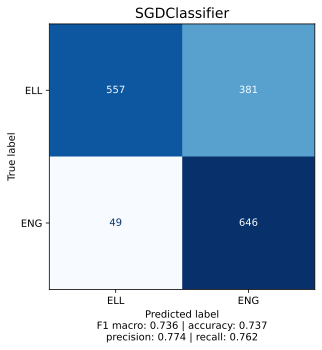

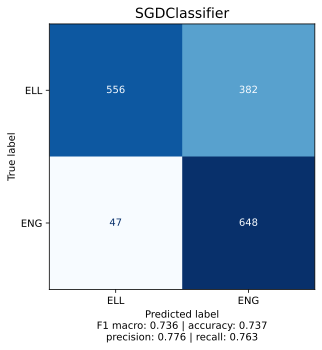

In [6]:
df = pd.read_csv(TEXT_EMBS, encoding='utf-8')

df, labels = encode_labels(df, 'label')

df['gpt2'] = df['gpt2'].apply(literal_eval).apply(np.array)
df['gpt2'] = df['gpt2'].apply(lambda x: x.reshape(-1))  # flatten the array

X = pd.concat([df['gpt2'].apply(pd.Series).rename(columns=lambda x: f"emb_{x}"),
               df['text']], axis=1)
y = df['label']

gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df['user_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, end="\n\n")

# post_vect = TfidfVectorizer(ngram_range=(1, 5), lowercase=False, binary=True)
char_vect = TfidfVectorizer(ngram_range=(1, 5), analyzer='char')

for i, row in models_df.iterrows():
    model = row['model']
    base = row['base']
    params = row['params']
    char_params = row['char_params']
    # pos_params = row['pos_params']

    cxf = ColumnTransformer([
        ('chars', char_vect, 'text'),
        # ('postg', post_vect, 'pos_tags'),
    ], remainder='passthrough')

    pipe = Pipeline([
        ('cxf', cxf),
        ('clf', base)
    ])

    print(f"{model:=^80}")
    print(f"With maxlen='none'".center(80, "-"))
    gs_grid = GridSearchCV(pipe, {**params, **char_params},
                           cv=10, scoring='f1_macro', n_jobs=-1, verbose=5)
    gs_grid.fit(X_train, y_train)
    print("Best hyperparameters:", gs_grid.best_params_, sep="\n", end="\n\n")
    y_pred = gs_grid.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred), end="\n\n")
    cm = confusion_matrix(y_test, y_pred)
    _confusion_matrix.plot_cm(cm, pipe=pipe, report=report, labels=labels, colorbar=False, export=True, comment=f'{model}_embs_char_none')
    gs_results = pd.DataFrame(gs_grid.cv_results_)
    gs_results['model'] = model
    gs_results['maxlen'] = 'none'
    all_results = pd.concat([all_results, gs_results])

    print(f"{model} done", end="\n\n")

In [7]:
# sort values in params column
all_results['params'] = all_results['params'].apply(lambda x: str(x))
all_results = all_results.sort_values(by='params')
all_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_cxf__chars__max_features,params,split0_test_score,split1_test_score,split2_test_score,...,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,model,maxlen
1,21.344836,0.655287,1.514134,0.075096,0.0001,1000,"{'clf__alpha': 0.0001, 'cxf__chars__max_featur...",0.796041,0.823446,0.765772,...,0.798426,0.810911,0.859822,0.880414,0.830025,0.820306,0.034829,3,LSVM,none
1,21.721014,0.878652,1.601179,0.106541,0.0001,1000,"{'clf__alpha': 0.0001, 'cxf__chars__max_featur...",0.776774,0.822795,0.766064,...,0.807840,0.821430,0.845049,0.886463,0.824873,0.817104,0.033466,4,LogReg,none
2,23.148976,0.767448,1.710550,0.223924,0.0001,2500,"{'clf__alpha': 0.0001, 'cxf__chars__max_featur...",0.785944,0.813684,0.771545,...,0.804475,0.818790,0.892429,0.888866,0.827651,0.822476,0.038958,2,LSVM,none
2,22.295931,0.664518,1.709277,0.093758,0.0001,2500,"{'clf__alpha': 0.0001, 'cxf__chars__max_featur...",0.789516,0.827714,0.783208,...,0.809978,0.793958,0.861038,0.892467,0.829481,0.821477,0.034027,2,LogReg,none
3,26.918577,1.356664,1.912459,0.140105,0.0001,5000,"{'clf__alpha': 0.0001, 'cxf__chars__max_featur...",0.805488,0.823494,0.776151,...,0.805568,0.822275,0.886361,0.878711,0.835687,0.825552,0.035397,1,LSVM,none
3,24.674624,1.036927,1.766438,0.086596,0.0001,5000,"{'clf__alpha': 0.0001, 'cxf__chars__max_featur...",0.799758,0.825962,0.773536,...,0.807445,0.825344,0.862238,0.888883,0.836756,0.826143,0.033145,1,LogReg,none
0,20.894203,0.371157,1.474899,0.095958,0.0001,500,"{'clf__alpha': 0.0001, 'cxf__chars__max_featur...",0.788733,0.809769,0.768450,...,0.812974,0.838182,0.847652,0.881487,0.805998,0.816171,0.031664,4,LSVM,none
0,21.697298,0.788317,1.560949,0.132113,0.0001,500,"{'clf__alpha': 0.0001, 'cxf__chars__max_featur...",0.773165,0.831385,0.763421,...,0.806989,0.825169,0.854951,0.886361,0.822017,0.818287,0.037919,3,LogReg,none
5,20.136889,1.133082,1.640952,0.169753,0.001,1000,"{'clf__alpha': 0.001, 'cxf__chars__max_feature...",0.745812,0.792505,0.755328,...,0.805404,0.811685,0.868515,0.882292,0.810286,0.802881,0.045368,7,LSVM,none
5,20.076417,0.742890,1.721057,0.194743,0.001,1000,"{'clf__alpha': 0.001, 'cxf__chars__max_feature...",0.739507,0.786155,0.750283,...,0.794155,0.804194,0.869473,0.882664,0.801312,0.800140,0.046986,8,LogReg,none


In [8]:
all_results = all_results.reset_index(drop=True)
all_results.to_csv('all_results_lsvm_logreg_embs_char.csv', index=False, encoding='utf-8')

In [9]:
with pd.option_context('display.max_rows', None):
    all_res = all_results[['model', 'maxlen', 'params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    all_res['params'] = all_res['params'].apply(lambda x: literal_eval(x))
    all_res['alpha'] = all_res['params'].apply(lambda x: x['clf__alpha'])
    all_res['max_features'] = all_res['params'].apply(lambda x: x['cxf__chars__max_features'])
    all_res = all_res.drop(columns=['params'])
    all_res = all_res.rename(columns={'mean_test_score': 'F1-score', 'std_test_score': 'std'})
    all_res = all_res.sort_values(by=['model', 'maxlen', 'alpha', 'max_features'])
    all_res = all_res.groupby(['model', 'maxlen', 'alpha', 'max_features']).agg({'F1-score': 'mean', 'std': 'mean'})
    all_res = all_res.unstack('model')  # move model to columns and group by model
    all_res = all_res.swaplevel(axis=1).sort_index(axis=1)  # swap F1-score and std columns with model

    ipy_display(all_res)

# all_res.to_latex('all_results_lsvm_logreg_embs_pos-bin_char.tex', encoding='utf-8')

C:\Users\dimboump\AppData\Local\Temp\ipykernel_121824\1619751360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_res['params'] = all_res['params'].apply(lambda x: literal_eval(x))
C:\Users\dimboump\AppData\Local\Temp\ipykernel_121824\1619751360.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_res['alpha'] = all_res['params'].apply(lambda x: x['clf__alpha'])
C:\Users\dimboump\AppData\Local\Temp\ipykernel_121824\1619751360.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

model                           LSVM              LogReg          
                            F1-score       std  F1-score       std
maxlen alpha  max_features                                        
none   0.0001 500           0.816171  0.031664  0.818287  0.037919
              1000          0.820306  0.034829  0.817104  0.033466
              2500          0.822476  0.038958  0.821477  0.034027
              5000          0.825552  0.035397  0.826143  0.033145
       0.0010 500           0.794588  0.043006  0.802007  0.042843
              1000          0.802881  0.045368  0.800140  0.046986
              2500          0.805234  0.048806  0.804392  0.040521
              5000          0.807257  0.045744  0.802168  0.049665

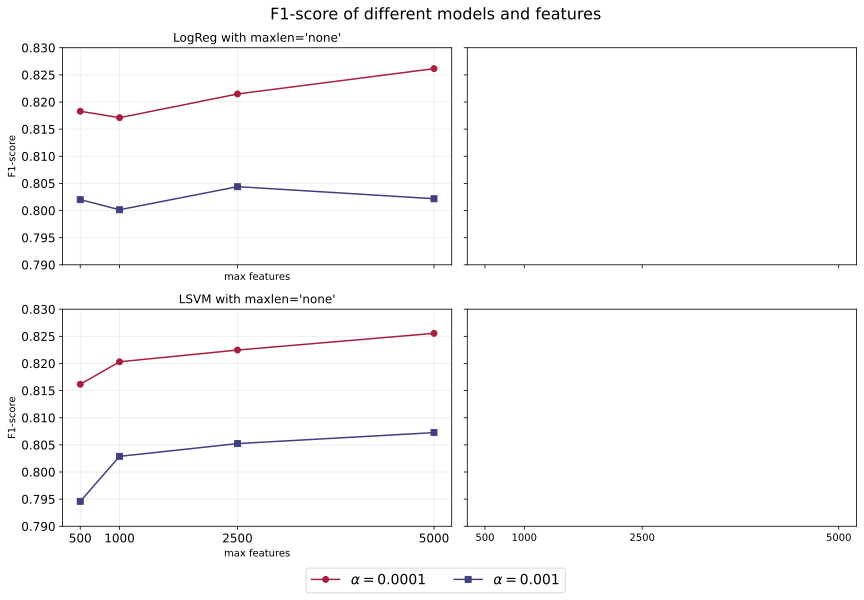

In [10]:

markers = {
    "0.0001": "o", 
    "0.001": "s", 
}

colors = {
    "0.0001": "#a52040", 
    "0.001": "#404080",
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True, sharex=True)

for i, model in enumerate(['LogReg', 'LSVM']):
    for j, maxlen in enumerate(['none']):
        for k, alpha in enumerate([0.0001, 0.001]):
            df = all_res.loc[(maxlen, alpha), model]
            mean = df['F1-score']
            std = df['std']
            max_feats = df.index
            axes[i, j].plot(max_feats, mean, color=colors[str(alpha)], marker=markers[str(alpha)], label=alpha)
            # axes[i, j].fill_between(max_feats, mean - std, mean + std, color=colors[max_feat.lower()], alpha=0.1)
            axes[i, j].set_title(f'{model} with {maxlen=}')
            axes[i, j].set_xticks(max_feats)
            axes[i, j].set_ylim(0.79, 0.83)
            axes[i, j].tick_params(axis='x', labelsize=12)
            axes[i, j].tick_params(axis='y', labelsize=12)
            axes[i, j].set_xlabel('max features')
            axes[i, j].set_ylabel('F1-score')
            axes[i, j].grid(zorder=0, alpha=0.25)

# set the title of the figure
fig.suptitle('F1-score of different models and features', fontsize=16)
fig.legend(handles=[plt.Line2D([0], [0], color=colors['0.0001'], marker=markers['0.0001'], label=r'$\alpha = 0.0001$'),
                    plt.Line2D([0], [0], color=colors['0.001'], marker=markers['0.001'], label=r'$\alpha = 0.001$')],
              loc='lower center', ncol=3, fontsize=14, bbox_to_anchor=(0.5, -0.05))
# fix legend overlapping with subplots
fig.subplots_adjust(bottom=0.5)
# set the spacing between the subplots and the title
fig.subplots_adjust(top=1.0)
# set the spacing between the subplots
fig.tight_layout()
